In [1]:
!python --version

Python 3.10.12


In [2]:
import os
import sys
import json
from collections import Counter
import cv2
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

#from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
#Tensorflow contains the array_to_img, imag_to_array and load_img. Whereas keras has ImageDataGenerator
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout,Flatten, Dense
from keras.utils import to_categorical

## Exploring the dataset

### Counting the images in the dataset

In [3]:
# Location of the dataset
!ls ../input/flower-classification-dataset/

files  labels.csv


In [4]:
#Looking what is inside files folder and labels.csv
path = "../input/flower-classification-dataset/"
df = pd.read_csv(os.path.join(path, "labels.csv"))
df.tail(5)

,image_id,category
18535,18535,22
18536,18536,91
18537,18537,78
18538,18538,74
18539,18539,29


In [5]:
X = []
y = []
for image, label in tqdm(zip(df.image_id.values, df.category.values), total= len(df)):
    try:
        xt = np.array(Image.open(os.path.join(path, f"files/{image}.jpg")).resize((128, 128)))
        yt = label
        X.append(xt)
        y.append(yt)
    except:
        print(os.path.join(path, f"files/{image}.jpg"))

X = np.array(X)
y = np.array(y)
X.shape, y.shape

  0%|          | 0/18540 [00:00<?, ?it/s]

((18540, 128, 128, 3), (18540,))

In [6]:
files = os.listdir(os.path.join(path, "files"))
print(f"The total number of images in the dataset are: {len(files)}")

The total number of images in the dataset are: 18540


<p>Checking if the number of images in the datset matches the number of labels in the dataset</p>

In [7]:
print(f"The total number of points in the label are: {len(df)}")

The total number of points in the label are: 18540


## Splitting the dataset

In [8]:
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [9]:
train_y = to_categorical(train_y)
test_y = to_categorical(test_y)
train_y.shape, test_y.shape # Returning the shape of train_y and test_y

((14832, 103), (3708, 103))

In [10]:
# Checking the shape of train_X, test_X
train_X.shape, test_y.shape

((14832, 128, 128, 3), (3708, 103))

## Exploring the images in the dataset

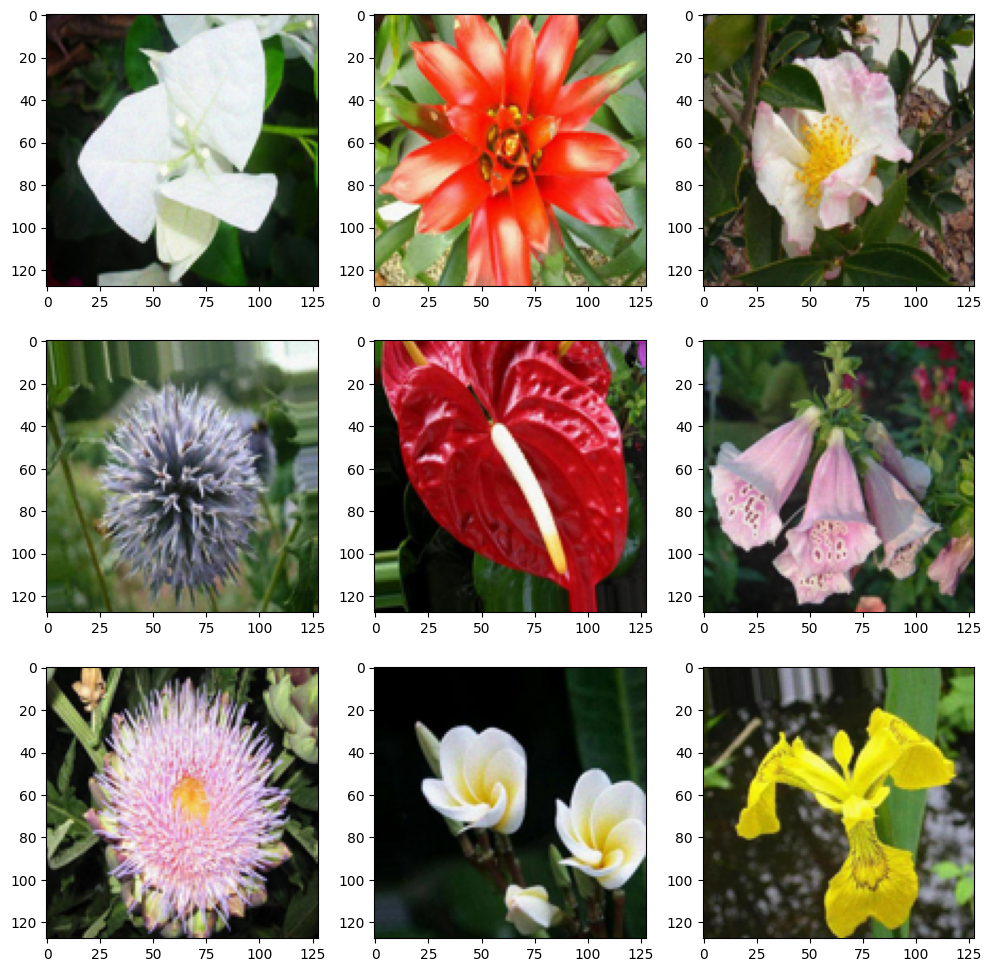

In [11]:
# Plot the first few images
plt.figure(figsize = (12, 12))
for i in range(9):
    # Define the subplot
    plt.subplot(330 + 1 + i)
    # plot raw pixel data
    plt.imshow(train_X[i])
# show the figure
plt.show() 

#### Lets explore the class distribution for now

<Axes: xlabel='category'>

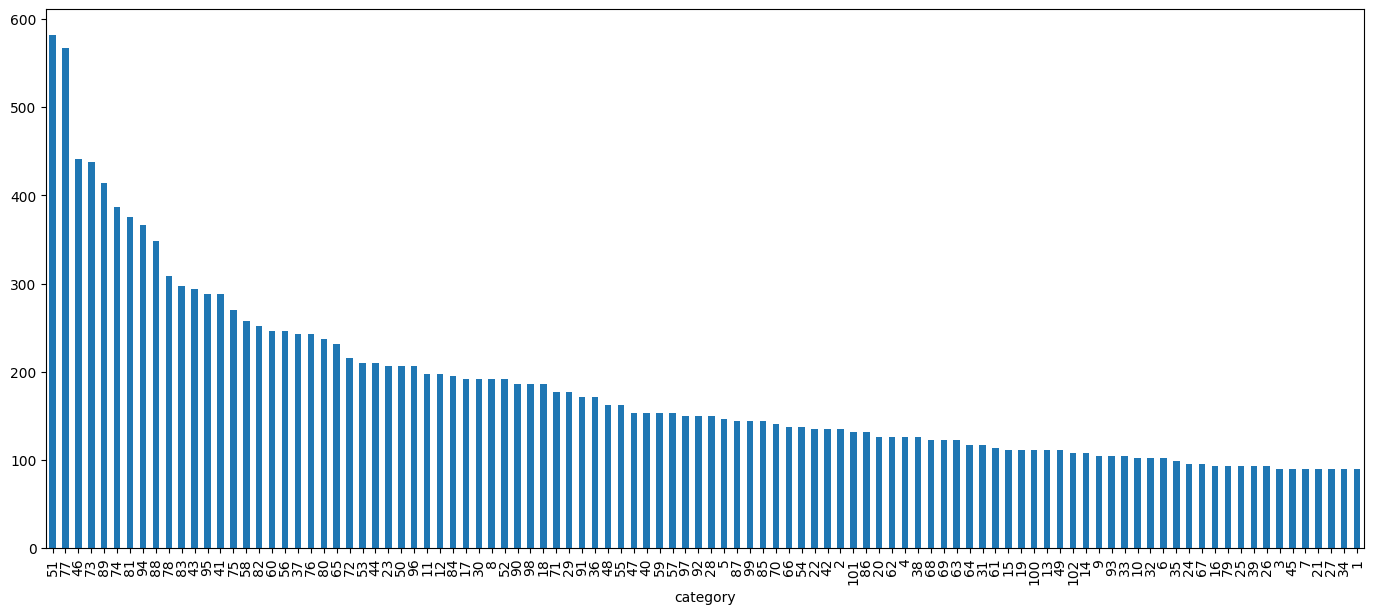

In [12]:
plt.figure(figsize = (17, 7))
df["category"].value_counts().plot(kind = "bar")

In [13]:
heights = []
widths = []
for image in tqdm(os.listdir(os.path.join(path, "files"))):
    ht , wt = Image.open(os.path.join(path, f"files/{image}")).size
    heights.append(ht)
    widths.append(wt)

  0%|          | 0/18540 [00:00<?, ?it/s]

In [14]:
Counter(heights), Counter(widths) 

(Counter({500: 18540}), Counter({500: 18540}))

In [15]:
!rm -rf preview
!mkdir preview

In [16]:
datagen = ImageDataGenerator(
        rotation_range = 40, # rotates the image with range of -40 t0 +40
        width_shift_range = 0.2, # shifts the image horizontally by a fraction of total width
        height_shift_range = 0.2, # shifts the image vertically by a fraction of total height
        shear_range = 0.2, # applies shearing byt distorting the shape of the image
        zoom_range = 0.2, # zooms in the image
        horizontal_flip = True, # filps the image horizontally
        fill_mode = "nearest") # determines the strategy to fill new pixels with nearest neighbor

img = load_img(os.path.join(path, f"files/0.jpg")) # loads a image which is in the file folder using the path
x = img_to_array(img) # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape) # this is a Numpy array with shape (1, 3, 150, 150) = (1, height, width, channels)


i = 0
for batch in datagen.flow(x, batch_size=1,
                          save_to_dir="preview", save_prefix="f", save_format="jpg"):
    i += 1
    if i > 20:
        break

In [17]:
!ls preview

f_0_1474.jpg  f_0_277.jpg   f_0_4118.jpg  f_0_590.jpg	f_0_9462.jpg
f_0_1703.jpg  f_0_3202.jpg  f_0_4282.jpg  f_0_6580.jpg
f_0_1773.jpg  f_0_3412.jpg  f_0_5531.jpg  f_0_8077.jpg
f_0_1974.jpg  f_0_3883.jpg  f_0_5546.jpg  f_0_8695.jpg
f_0_2727.jpg  f_0_3942.jpg  f_0_5804.jpg  f_0_9086.jpg


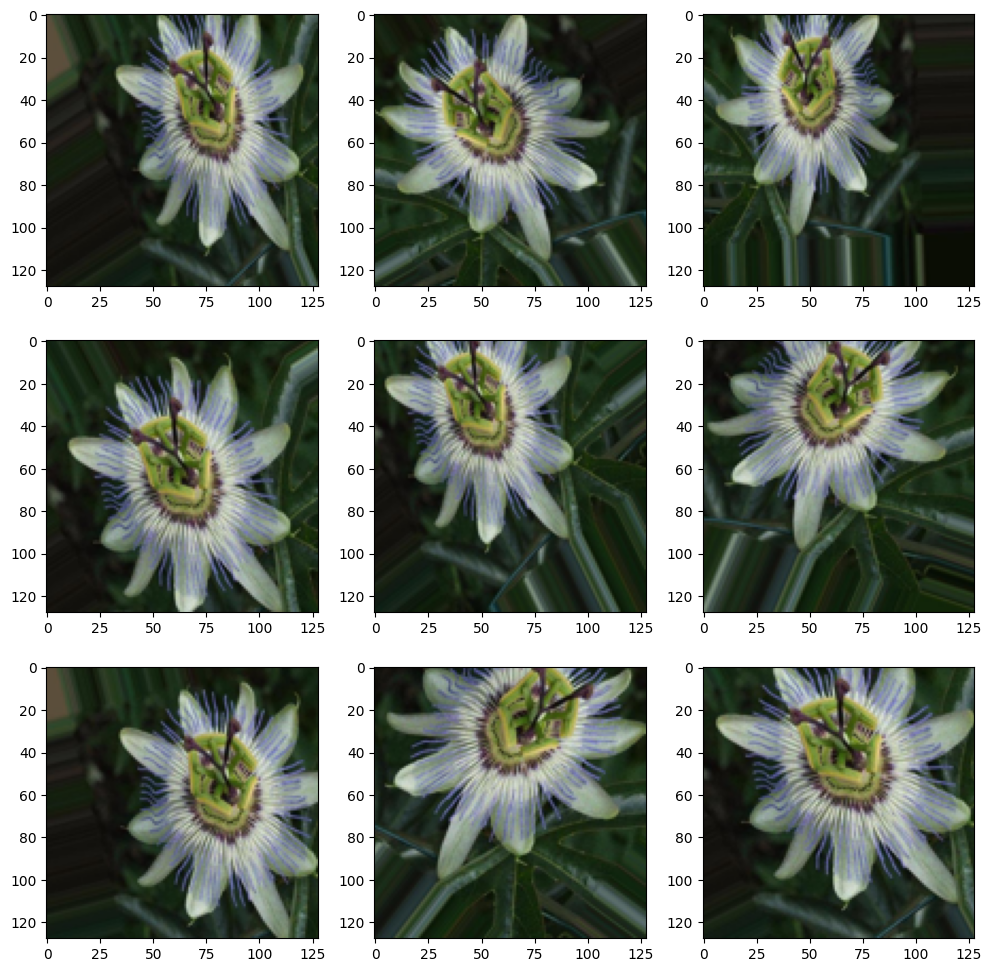

In [18]:
x = []
for image in os.listdir("preview"):
    xt = np.array(Image.open(os.path.join("preview", image)).resize((128, 128)))
    x.append(xt)
    
plt.figure(figsize=(12, 12))
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.imshow(x[i])
plt.show()

## Building our Classifier model

In [19]:
model = Sequential()
model.add(Conv2D(16, (3, 3), padding='same', input_shape=(128, 128, 3)))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(103))
model.add(Activation("softmax"))

model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])

In [20]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 16)      448       
                                                                 
 activation (Activation)     (None, 128, 128, 16)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        4640      
                                                                 
 activation_1 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                    

In [21]:
batch_size = 16

train_datagen = ImageDataGenerator(
                rescale = 1./255,
                shear_range = 0.2,
                zoom_range = 0.2,
                horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [22]:
train_generator = train_datagen.flow(
                train_X,
                train_y,
                batch_size = batch_size,
                shuffle = True
                )

validation_generator = test_datagen.flow(
                    test_X,
                    test_y,
                    shuffle = False
                    )

In [23]:
gen = model.fit(
     train_generator,
     epochs = 50,
     validation_data = validation_generator)

Epoch 1/50
927/927 [==============================] - 197s 211ms/step - loss: 3.8416 - accuracy: 0.0959 - val_loss: 3.1561 - val_accuracy: 0.2087
Epoch 2/50
927/927 [==============================] - 194s 210ms/step - loss: 3.0943 - accuracy: 0.2102 - val_loss: 2.6372 - val_accuracy: 0.2996
Epoch 3/50
927/927 [==============================] - 194s 210ms/step - loss: 2.6355 - accuracy: 0.3043 - val_loss: 2.1254 - val_accuracy: 0.4385
Epoch 4/50
927/927 [==============================] - 192s 207ms/step - loss: 2.3184 - accuracy: 0.3771 - val_loss: 1.9369 - val_accuracy: 0.4755
Epoch 5/50
927/927 [==============================] - 192s 208ms/step - loss: 2.0526 - accuracy: 0.4399 - val_loss: 1.6728 - val_accuracy: 0.5402
Epoch 6/50
927/927 [==============================] - 193s 208ms/step - loss: 1.8613 - accuracy: 0.4852 - val_loss: 1.4903 - val_accuracy: 0.5804
Epoch 7/50
927/927 [==============================] - 193s 208ms/step - loss: 1.6625 - accuracy: 0.5318 - val_loss: 1.5323 -

## Plotting the Performance of the model

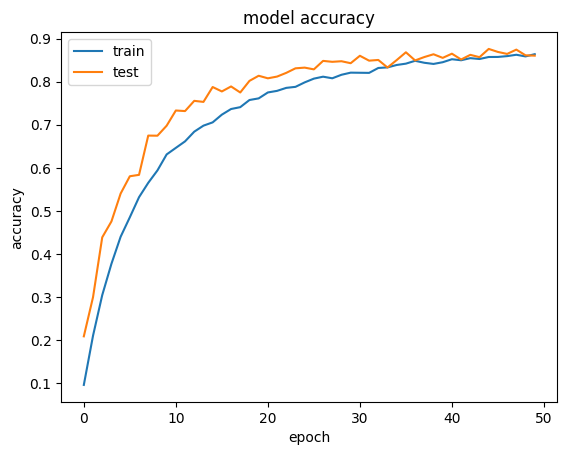

In [24]:
# summarize history for accuracy
plt.plot(gen.history['accuracy'])
plt.plot(gen.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

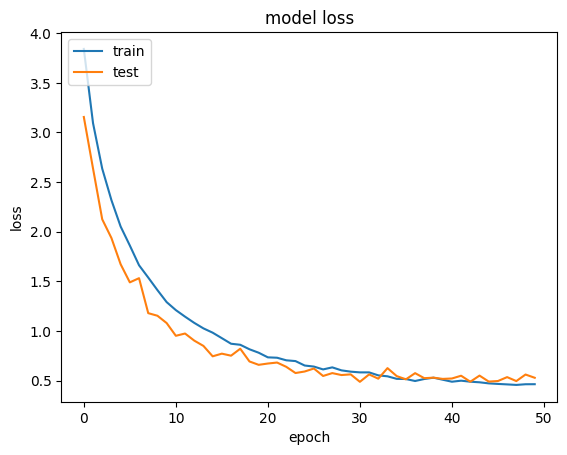

In [25]:
# summarize history for loss
plt.plot(gen.history['loss'])
plt.plot(gen.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()